In [1]:
#New outlier detector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from sktime.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [3]:
plt.rcParams['figure.figsize'] = [14, 8]

np.random.seed(3141592)

DATA_PATH = "data"

X_train = pd.read_csv(f'{DATA_PATH}/X_train.csv', index_col='id')
y_train = pd.read_csv(f'{DATA_PATH}/y_train.csv', index_col='id')
X_test = pd.read_csv(f'{DATA_PATH}/X_test.csv', index_col='id')
data = np.concatenate([X_train, y_train], axis=1)

The goal is to create a different plot than previous.
That shows, 
1) For different combination of OD, which points/ how many points will be considered as outliers. 

2) Or for every points, which ODs have considered it to be a outliers, so we could make a majority voting afterwards. 
>>More doable

Second idea:
We try to create a class for each model, 


We try to create a class that receives as input a series of model's names and the corresponding parameters, then return an array that indicates, for every configuration of outlier detector(same model with different sets of parametes are consiered different configurations), which are the indices of outliers.

In [4]:
Example_input = [ {"IsolationForest":{'n_estimators': 50}},
                {"IsolationForest":{'n_estimators': 100}},
                {"IsolationForest":{'n_estimators': 200}}
                 ]

#,
                #{"EllipticEnvelope":{'contamination': 0.01}
                 #{"EllipticEnvelope": {'contamination': 0.1}},
                #{"EllipticEnvelope": {'contamination': 0.5}}
                #{"LocalOutlierFactor": {'n_neighbors': 10}},
                #{"LocalOutlierFactor": {'n_neighbors': 25}},
                #{"LocalOutlierFactor": {'n_neighbors': 50}} ]

In [5]:
Imputer = IterativeImputer(initial_strategy='median', n_nearest_features=5)
data_imputed = Imputer.fit_transform(X_train)

In [6]:
class ReturnOutlierPrediction:
    def __init__(self, detector_param_list) :
        models = []
        for item in detector_param_list:
            for key, value in item.items():
                model =  eval(key)(**value)
                print(key,value,model)
                models.append(model)

        self.models = models

    def fit(self, data):
        for model in self.models:
            print("fit",model)
            model.fit(data)

    def predict(self,data):
        prediction = {}
        for i, model in enumerate(self.models):
            if  type(model).__name__ == "LocalOutlierFactor": #need to set novelty param
                pred = model.fit_predict(data)
                prediction[i] = [index for index, element in enumerate(pred) if element == -1]
            else:
                pred = model.predict(data)
                prediction[i] = [index for index, element in enumerate(pred) if element == -1]

        return prediction

In [7]:
OutlierPredictions = ReturnOutlierPrediction(Example_input)
OutlierPredictions.fit(data_imputed)
prediction = OutlierPredictions.predict(data_imputed)

IsolationForest {'n_estimators': 50} IsolationForest(n_estimators=50)
IsolationForest {'n_estimators': 100} IsolationForest()
IsolationForest {'n_estimators': 200} IsolationForest(n_estimators=200)
fit IsolationForest(n_estimators=50)
fit IsolationForest()
fit IsolationForest(n_estimators=200)


In [8]:
def plot_detector_votings(Detector_class, Prediction):
    detectors = Detector_class.models
    outliers_dict = {}
    for model_index, prediction in Prediction.items():
        for p in prediction:# for every outlier index in the prediction 
            if p not in outliers_dict.keys():
                outliers_dict[p] = []
            outliers_dict[p].append(model_index)
    #now I hava a dictionary where the key is the outliers and values is a list of models
    #that mark it as outlier
    num_detectors = len(detectors)
    result_outliers_coord = {}

    #print("outliers dict", outliers_dict)

    for outlier, detectors_marked in outliers_dict.items():
        zero_coord = [0] * num_detectors
        result_outliers_coord[outlier] = zero_coord
        for detector_index in detectors_marked:
            result_outliers_coord[outlier][detector_index] = 1
    
    x = result_outliers_coord.keys()
    #y = [ int("".join(map(str,r))) for r in result_outliers_coord.values()]
    y = [sum(r) for r in result_outliers_coord.values()]
    plt.scatter(x,y)
    plt.show()
    return result_outliers_coord

# we plot every possible outliers(union of all outliers predicted by all models) in the x axis and the y coordinates counts how many models
#  have predicted it as outliers
   

    


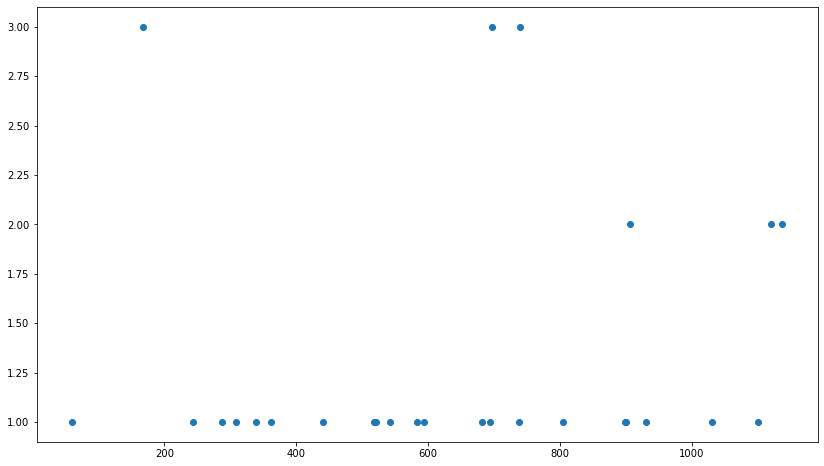

In [9]:
res = plot_detector_votings(OutlierPredictions, prediction)


Followss Eric's Idea to implement the Outlier Detector class

In [51]:
from pyod.models.ecod import ECOD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.knn import KNN
from sklearn.covariance import EllipticEnvelope
#from pyod.models.mcd import MCD
#from scipy import stats
from sklearn.cluster import DBSCAN
import math 


In [40]:
X_train = pd.read_csv("data/X_train.csv", index_col="id")
y_train = pd.read_csv("data/y_train.csv", index_col="id").to_numpy().ravel()
pre_od_pipeline = Pipeline(
    [
        ("imputer", IterativeImputer(initial_strategy="median", n_nearest_features=5)),
        ("scaler", StandardScaler()),
        ("selector", SelectKBest(score_func=f_regression, k=175)),
    ]
)
X_train_pre_od = pre_od_pipeline.fit_transform(X_train, y_train)


In [ ]:
class BaseOutlierDetector:
    """ 
    n_detectors: Number of outlier detectors among which we take the majority voting, default = 3. 
    
    """
    
    def __init__(self, n_detectors = 3):
        pass
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X

In [30]:
len(np.zeros(X_train.shape[0]))


1212

In [69]:
class BaseOutlierDetector:
    # returned value = 1 for outliers, 0 for inliers
    def __init__(self):
        self.models = {
            'IForest': IForest(),
            'OCSVM': OCSVM(),
            'KNN': KNN(),
            'LOF': LOF(),
            'DBSCAN': DBSCAN()
        }

    def fit(self, X, n_detector=3):
        outlier_indicators = np.zeros(X.shape[0])#initialize a counter for each point

        for i, (model_name, model) in enumerate(self.models.items()):
            if i < n_detector:
                model.fit(X)
                if model_name == "LOF":
                    predictions = model.fit_predict(X)
                else:
                    predictions = model.predict(X)
                indices = [index for index, element in enumerate(predictions) if element == 1]
                outlier_indicators += (predictions == 1)

        # take the majority vote, i.e. the counter is greater than half of the number of detectors 
        returned_value = outlier_indicators >= math.ceil(n_detector/2)

        return [1  if value == True else 0 for value in returned_value]

    def fit_predict(self, X, n_detector=3):
        return self.fit(X, n_detector)

# Example usage:
if __name__ == "__main__":
    outlier_detector = BaseOutlierDetector()
    results = outlier_detector.fit_predict(X_train_pre_od, n_detector=3)
    print(results)
    res_indices = [index for index, element in enumerate(results) if element == 1]
    print(len(res_indices), res_indices)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [52]:
math.ceil(3/2)

2

(array([  48.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1164.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

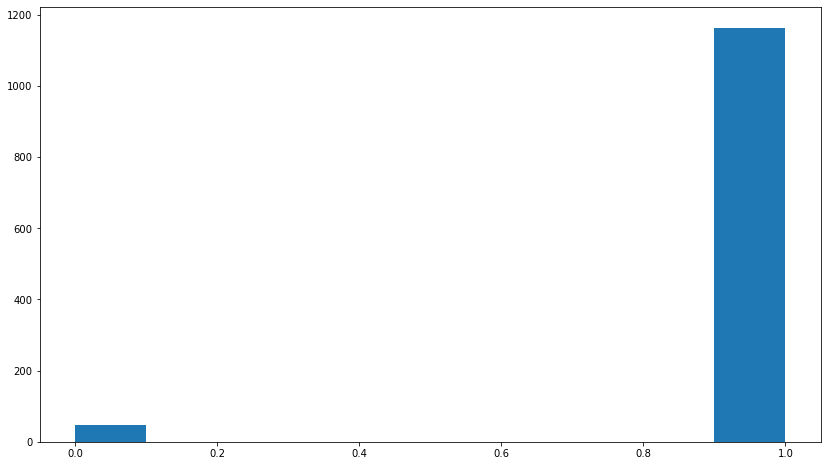

In [47]:
plt.hist(results)

In [ ]:
class ReturnOutlierPrediction:
    def __init__(self, detector_param_list) :
        models = []
        for item in detector_param_list:
            for key, value in item.items():
                model =  eval(key)(**value)
                print(key,value,model)
                models.append(model)

        self.models = models

    def fit(self, data):
        for model in self.models:
            print("fit",model)
            model.fit(data)

    def predict(self,data):
        prediction = {}
        for i, model in enumerate(self.models):
            if  type(model).__name__ == "LocalOutlierFactor": #need to set novelty param
                pred = model.fit_predict(data)
                prediction[i] = [index for index, element in enumerate(pred) if element == -1]
            else:
                pred = model.predict(data)
                prediction[i] = [index for index, element in enumerate(pred) if element == -1]

        return prediction